In [2]:
from __future__ import annotations

import numpy as np

import torch
import spacy

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from nltk.stem.snowball import SnowballStemmer

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

from ordpy import ordinal_distribution, complexity_entropy
from nolds import lyap_r

import matplotlib.pyplot as plt

from tqdm import tqdm

import logging

/Users/timmiakov/Code/ideal-guacamole/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Semantic Trajectories

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Device:', device)

nlp = spacy.load("ru_core_news_sm")
nlp.max_length = 1500000
stemmer = SnowballStemmer("russian")
    
tokenizer = AutoTokenizer.from_pretrained("seara/rubert-base-cased-russian-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("seara/rubert-base-cased-russian-sentiment").to(device)

Device: mps


In [4]:
BAD_SYMBOLS = '!\"#$%&\'()*,+,-./:;<=>?@[\\]^_`{|}~—…'

def prepare_text(
    text_path: str, 
    how: str = 'default',
    seq_len: int = None
) -> list:
    """
    Подготавливает текст:
    1) Очищает от bad symbols, удаляет лишние пробелы
    2) По выбранному методы подгатавливает слова в тексте:
        default - просто lower слова
        lemmas - леммы слов
        stems - стемы слов

    Args:
        text_path (str): Путь до txt файла с текстом
        how (str, optional): Метод препроцессинга текста
        seq_len (int, optional): Можно ограничить длину возвращаемой последовательности с начала
    """
    
    with open(text_path, 'r', encoding='Windows 1251') as f:
        text = f.read().lower().strip()
  
    for bas_symbol in BAD_SYMBOLS:
        text = text.replace(bas_symbol, ' ')
    
    doc = nlp(text)
    if how == 'default':
        preprocessed_text = [token.text.lower() for token in doc if not token.is_stop and not token.is_space and not token.is_digit]
    elif how == 'lemmas':
        preprocessed_text = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_space and not token.is_digit]
    elif how == 'stems':
        preprocessed_text = [stemmer.stem(token.text).lower() for token in doc if not token.is_stop and not token.is_space and not token.is_digit]
    else:
        logging.error(f'Unknown preprocessing type: {how}')
        return None
    
    return preprocessed_text[:seq_len] if seq_len else preprocessed_text

In [5]:
seq_len = 50

text_name = 'Преступление_и_наказание.txt'
text = prepare_text(text_name, how='default', seq_len=seq_len)
lemmas = prepare_text(text_name, how='lemmas', seq_len=seq_len)
stems = prepare_text(text_name, how='stems', seq_len=seq_len)

Sentiment trajectory

In [22]:
def prepare_sentiment_trajectory(
    preprocessed_text,
    model,
    tokenizer
) -> list[float]:
    """
    {0: 'neutral', 1: 'positive', 2: 'negative'}
    """
    tokenized_words = []
    for word in tqdm(preprocessed_text):
        inputs = tokenizer(word, return_tensors="pt")
        tokenized_words.append(inputs)
        
    sentiment_traectory = []
    for inputs in tqdm(tokenized_words):
        inputs = inputs.to(device)
        outputs = model(**inputs)
        lprobs = torch.nn.functional.softmax(outputs.logits, dim=1)[0].tolist()
        sentiment_traectory.append(lprobs[1] if lprobs[1] > lprobs[2] else -lprobs[2])
    return sentiment_traectory

In [63]:
def prepare_sentiment_trajectory_dostoevsky(
    preprocessed_text
) -> list[float]:
    
    tokenizer = RegexTokenizer()
    model = FastTextSocialNetworkModel(tokenizer=tokenizer)


    results = model.predict(' '.join(preprocessed_text), k=5)
    trajectory = []
    for sentiment in results:
        #print(sentiment)
        #max_key = max(sentiment, key=sentiment.get)
        positive = sentiment['positive']
        negative = sentiment['negative']
        trajectory.append(positive if positive > negative else negative)
    
    return trajectory

In [23]:
words_sentiment_trajectory = prepare_sentiment_trajectory(text, model, tokenizer)

100%|██████████| 50/50 [00:00<00:00, 75.03it/s]


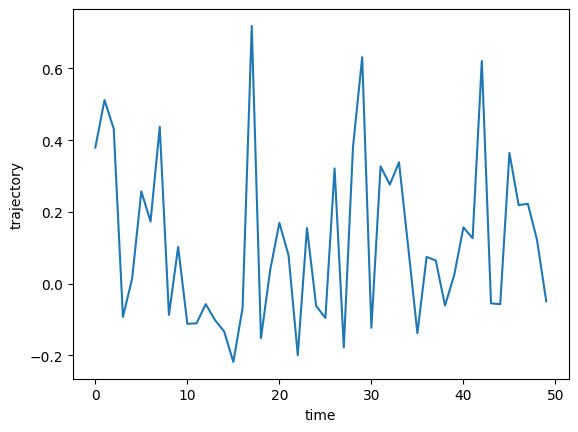

In [24]:
plt.plot(words_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [27]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 5}
lyap_exp = lyap_r(words_sentiment_trajectory, **lyap_kwargs)
lyap_exp

-0.005325646608753677

In [28]:
lemmas_sentiment_trajectory = prepare_sentiment_trajectory(lemmas, model, tokenizer)

100%|██████████| 50/50 [00:00<00:00, 84.97it/s]


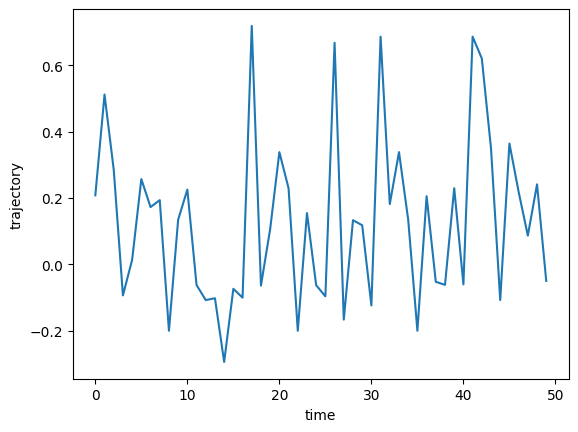

In [29]:
plt.plot(lemmas_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [30]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 5}
lyap_exp = lyap_r(lemmas_sentiment_trajectory, **lyap_kwargs)
lyap_exp

0.0038347456648947036

In [31]:
stems_sentiment_trajectory = prepare_sentiment_trajectory(stems, model, tokenizer)

100%|██████████| 50/50 [00:00<00:00, 78.93it/s]


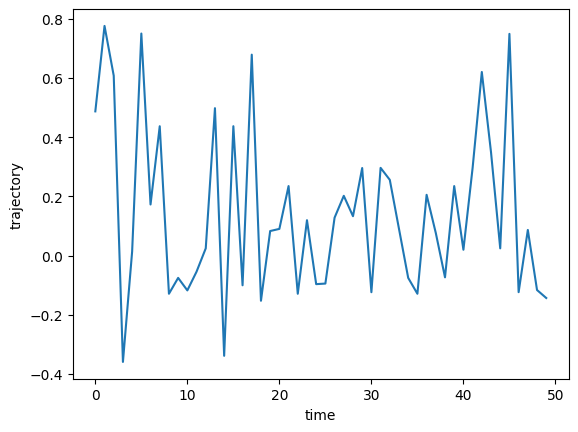

In [32]:
plt.plot(stems_sentiment_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [33]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 5}
lyap_exp = lyap_r(stems_sentiment_trajectory, **lyap_kwargs)
lyap_exp

0.018931037667963474

In [34]:
#word_sentiment_trajectory
ce_word_sentiment_trajectory = complexity_entropy(words_sentiment_trajectory, dx=3, probs=False)

#lemma_sentiment_trajectory
ce_lemma_sentiment_trajectory = complexity_entropy(lemmas_sentiment_trajectory, dx=3, probs=False)

#stem_sentiment_trajectory
ce_stems_sentiment_trajectory = complexity_entropy(stems_sentiment_trajectory, dx=3, probs=False)

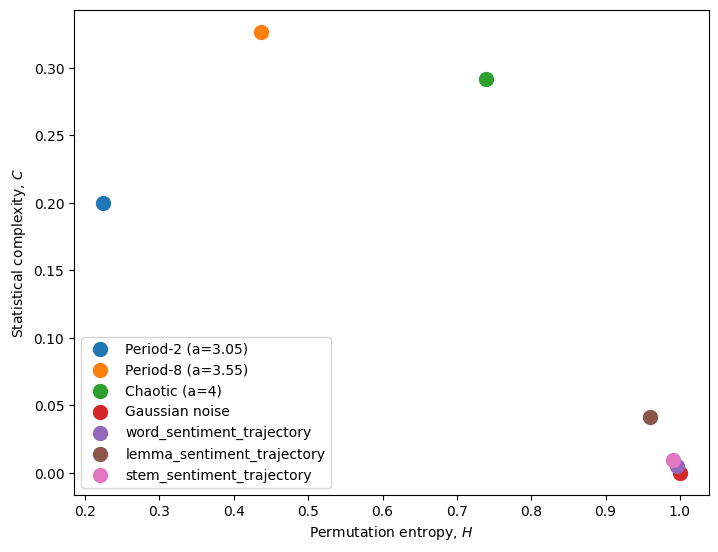

In [35]:
import numpy as np
import ordpy
from matplotlib import pylab as plt

def logistic(a=4, n=100000, x0=0.4):
    x = np.zeros(n)
    x[0] = x0
    for i in range(n - 1):
        x[i + 1] = a * x[i] * (1 - x[i])
    return(x)

f, ax = plt.subplots(figsize=(8.19, 6.3))

#examples
time_series = [logistic(a) for a in [3.05, 3.55, 4]]
time_series += [np.random.normal(size=100000)]
HC = [ordpy.complexity_entropy(series, dx=4) for series in time_series]
for HC_, label_ in zip(HC, ['Period-2 (a=3.05)',
                            'Period-8 (a=3.55)',
                            'Chaotic (a=4)',
                            'Gaussian noise']):
    ax.scatter(*HC_, label=label_, s=100)

ax.scatter(*ce_word_sentiment_trajectory, label='word_sentiment_trajectory', s=100)
ax.scatter(*ce_lemma_sentiment_trajectory, label='lemma_sentiment_trajectory', s=100)
ax.scatter(*ce_stems_sentiment_trajectory, label='stem_sentiment_trajectory', s=100)

ax.set_xlabel('Permutation entropy, $H$')
ax.set_ylabel('Statistical complexity, $C$')

ax.legend();

## Sentiment trajectories

In [36]:
tfidf_matrix = TfidfVectorizer().fit_transform(text)

In [37]:
svd_dim = 8
u, s, vT = svds(tfidf_matrix, k=svd_dim)

In [38]:
d2 = 1
semantic_trajectory = [u_i[0:d2] for u_i in u]

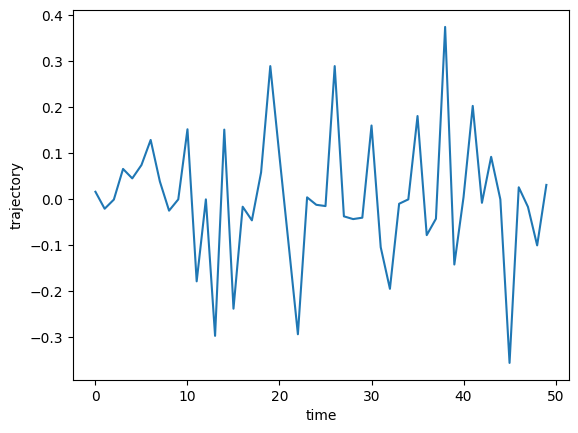

In [39]:
plt.plot(semantic_trajectory)
plt.xlabel('time')
plt.ylabel('trajectory')
plt.show()

In [41]:
lyap_kwargs = {"emb_dim": 6, "lag": 2, "min_tsep": 5}
lyap_exp = lyap_r(semantic_trajectory, **lyap_kwargs)
lyap_exp

-inf